# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
bUseFloyd = True
if not bUseFloyd:
    data_dir = './data'
else:
    # FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
    data_dir = '/input'
    print("Using data from Floyd directory")

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Using data from Floyd directory
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

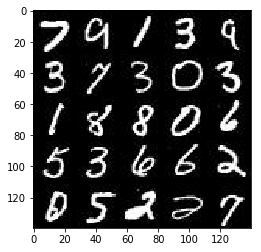

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

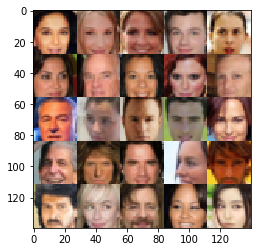

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        #alpha for leaky relu
        alpha = 0.2
        # Input layer is 28x28x3 (size of input images)
        # Note there is no batch norm in this layer. Kernel is 5, strides=2 reduces image size
        layer=0
        # t is the image width, height, channels. (images has )
        t=[int(x) for x in (images.shape[1:])]
        strides=3
        kernel=5        
        depth = strides*t[0]
        im = int(t[0] /strides)
        x1 = tf.layers.conv2d(images, depth, kernel, strides=strides, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        layer += 1
        depth *= strides
        im = int(im /strides)
        x2 = tf.layers.conv2d(relu1, depth, kernel, strides=strides, padding='same')
        # batch normalization
        bn2 = tf.layers.batch_normalization(x2, training=True)
        # leaky relu
        relu2 = tf.maximum(alpha * bn2, bn2)
      
        layer += 1
        depth *= strides
        im = int(im /strides)
        x3 = tf.layers.conv2d(relu2, depth, kernel, strides=strides, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # flatten to vector 
        flat = tf.reshape(relu3, (-1, im*im*depth))

        #logits will be used to calc cross-entropy loss
        logits = tf.layers.dense(flat, 1)
        #sigmoid will be used to calc probability
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=(not is_train)):
        alpha = 0.2
        layer=0
        #Use dropout during training only
        if is_train:
            keep_prob = 0.5
        else:
            keep_prob = 1.0
            
        #first tensor shape
        t = (2,2,256)
        # First fully connected layer
        x1 = tf.layers.dense(z, t[0]*t[1]*t[2])
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, t[0], t[1], t[2]))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        #dropout
        x1 = tf.nn.dropout(x1, keep_prob)

        layer +=1
        strides=2
        kernel=5
        depth = int(t[2]/strides)
        x2 = tf.layers.conv2d_transpose(x1, depth, kernel, strides=strides, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        #dropout
        x2 = tf.nn.dropout(x2, keep_prob)
             
        layer +=1
        depth = int(depth/strides)
        x3 = tf.layers.conv2d_transpose(x2, depth, kernel, strides=strides, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        layer +=1
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel, strides=strides, padding='same')
        out = tf.tanh(logits)        
        return out
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    is_train=True
    g_model = generator(input_z, out_channel_dim, is_train)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # label smoothing. Comments below show how to use labels without smoothing.
    labels_sm_real = tf.random_uniform(tf.shape(d_model_real), minval=0.7, maxval=1.2)
    labels_sm_fake = tf.random_uniform(tf.shape(d_model_fake), minval=0, maxval=0.3)

#     d_loss_real = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
#     d_loss_fake = tf.reduce_mean(
#         tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=labels_sm_real))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=labels_sm_fake))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    #Alternate means to penalize discrim. Use GradDescent and worse learning rate.(Not as effective)
    #d_train_opt = tf.train.GradientDescentOptimizer(learning_rate*10.0).minimize(d_loss, var_list=d_vars)
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    # Optimize. Using control_dependencies ONLY for generator so that it penalizes discriminator
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    #NOTE Gaussian sampling was skipped only because that meant modifying the 
    #   show_generator() too, which the Exercise prohibited.
    #  sampling from a gaussian distribution (loc is mean, scale is SD)
    #example_z = np.random.normal(loc=0.0, scale=0.3, size=(n_images, z_dim))

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
#Show a plot of the losses
def view_losses(losses, print_every):
    fig, ax = pyplot.subplots()
    step_list = [x* print_every for x in range(len(losses))]
    losses = np.array(losses) 
    pyplot.plot(step_list, losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(step_list, losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()
    pyplot.show()
    

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 10 
    show_every = 100 
    n_images = 25

    # Create the network
    input_real, input_z, learn = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    learn = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn, beta1)
       
    losses = []
    steps = 0    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2.0 #rescale the intensity range from (-.5,.5) to (-1,1)
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #NOTE Gaussian sampling was skipped only because that meant modifying the 
                #   show_generator() too, which the Exercise prohibited.
                # Sampling from a gaussian distribution (loc is mean, scale is SD)
                #batch_z = np.random.normal(loc=0.0, scale=0.3, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                # run gen twice to prevent discrim loss going to 0
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Step {}, Epoch {}/{}...".format(steps, epoch_i+1, epoch_count))
                    print("D Loss: {:.4f}...".format(train_loss_d))
                    print("G Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
                    view_losses(losses, print_every)

        #final result
        show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
        view_losses(losses, print_every)

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 10, Epoch 1/2...
D Loss: 1.2759...
G Loss: 0.6461
Step 20, Epoch 1/2...
D Loss: 1.2139...
G Loss: 0.7209
Step 30, Epoch 1/2...
D Loss: 1.2000...
G Loss: 0.7873
Step 40, Epoch 1/2...
D Loss: 1.2765...
G Loss: 0.6578
Step 50, Epoch 1/2...
D Loss: 1.2200...
G Loss: 0.7356
Step 60, Epoch 1/2...
D Loss: 1.1426...
G Loss: 0.7720
Step 70, Epoch 1/2...
D Loss: 1.1757...
G Loss: 0.7194
Step 80, Epoch 1/2...
D Loss: 1.2299...
G Loss: 0.7230
Step 90, Epoch 1/2...
D Loss: 1.2629...
G Loss: 0.7459
Step 100, Epoch 1/2...
D Loss: 1.2169...
G Loss: 0.7853


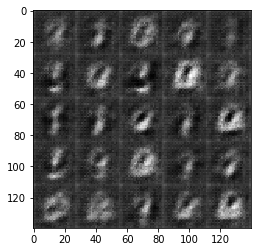

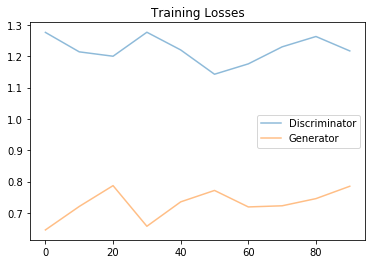

Step 110, Epoch 1/2...
D Loss: 1.2060...
G Loss: 0.7605
Step 120, Epoch 1/2...
D Loss: 1.1799...
G Loss: 0.7475
Step 130, Epoch 1/2...
D Loss: 1.3625...
G Loss: 0.7798
Step 140, Epoch 1/2...
D Loss: 1.2089...
G Loss: 0.7700
Step 150, Epoch 1/2...
D Loss: 1.1934...
G Loss: 0.7376
Step 160, Epoch 1/2...
D Loss: 1.2940...
G Loss: 0.7866
Step 170, Epoch 1/2...
D Loss: 1.1876...
G Loss: 0.7975
Step 180, Epoch 1/2...
D Loss: 1.2332...
G Loss: 0.7911
Step 190, Epoch 1/2...
D Loss: 1.2163...
G Loss: 0.8105
Step 200, Epoch 1/2...
D Loss: 1.2571...
G Loss: 0.8159


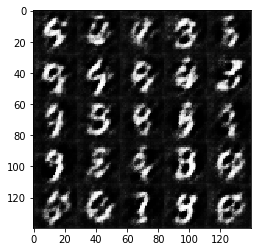

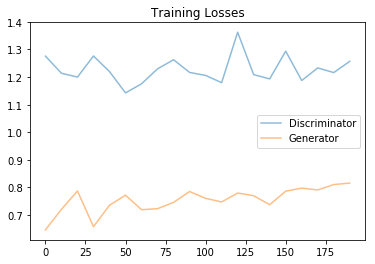

Step 210, Epoch 1/2...
D Loss: 1.1957...
G Loss: 0.7443
Step 220, Epoch 1/2...
D Loss: 1.1450...
G Loss: 0.7491
Step 230, Epoch 1/2...
D Loss: 1.2647...
G Loss: 0.9221
Step 240, Epoch 1/2...
D Loss: 1.1378...
G Loss: 0.8097
Step 250, Epoch 1/2...
D Loss: 1.2898...
G Loss: 0.8472
Step 260, Epoch 1/2...
D Loss: 1.1493...
G Loss: 0.8164
Step 270, Epoch 1/2...
D Loss: 1.1744...
G Loss: 0.7536
Step 280, Epoch 1/2...
D Loss: 1.1692...
G Loss: 0.8043
Step 290, Epoch 1/2...
D Loss: 1.1350...
G Loss: 0.8077
Step 300, Epoch 1/2...
D Loss: 1.1177...
G Loss: 0.8228


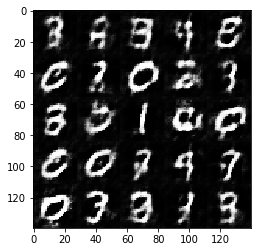

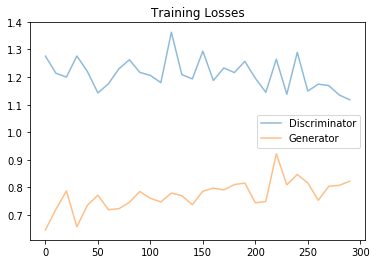

Step 310, Epoch 1/2...
D Loss: 1.1795...
G Loss: 0.9158
Step 320, Epoch 1/2...
D Loss: 1.1267...
G Loss: 0.8013
Step 330, Epoch 1/2...
D Loss: 1.1571...
G Loss: 0.7694
Step 340, Epoch 1/2...
D Loss: 1.1549...
G Loss: 0.8701
Step 350, Epoch 1/2...
D Loss: 1.2180...
G Loss: 0.8308
Step 360, Epoch 1/2...
D Loss: 1.0760...
G Loss: 0.8695
Step 370, Epoch 1/2...
D Loss: 1.2144...
G Loss: 0.7136
Step 380, Epoch 1/2...
D Loss: 1.1240...
G Loss: 0.7851
Step 390, Epoch 1/2...
D Loss: 1.1254...
G Loss: 0.8536
Step 400, Epoch 1/2...
D Loss: 1.2110...
G Loss: 0.8612


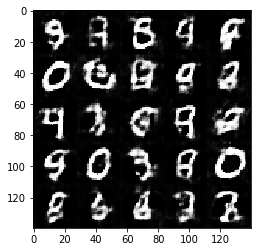

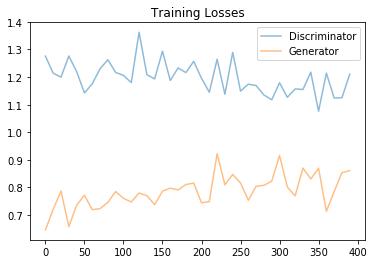

Step 410, Epoch 1/2...
D Loss: 1.1169...
G Loss: 0.9934
Step 420, Epoch 1/2...
D Loss: 1.1780...
G Loss: 0.8433
Step 430, Epoch 1/2...
D Loss: 1.0978...
G Loss: 0.8266
Step 440, Epoch 1/2...
D Loss: 1.1481...
G Loss: 0.7767
Step 450, Epoch 1/2...
D Loss: 1.1029...
G Loss: 0.8149
Step 460, Epoch 1/2...
D Loss: 1.0618...
G Loss: 0.9142
Step 470, Epoch 2/2...
D Loss: 1.0905...
G Loss: 0.7364
Step 480, Epoch 2/2...
D Loss: 1.1200...
G Loss: 0.7819
Step 490, Epoch 2/2...
D Loss: 1.1007...
G Loss: 0.8760
Step 500, Epoch 2/2...
D Loss: 1.1398...
G Loss: 0.8085


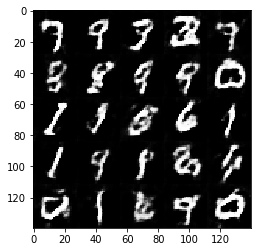

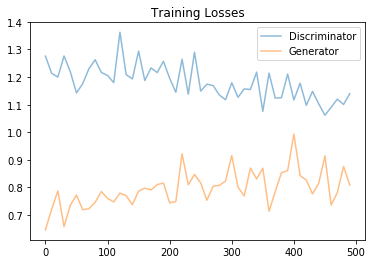

Step 510, Epoch 2/2...
D Loss: 1.1778...
G Loss: 0.8820
Step 520, Epoch 2/2...
D Loss: 1.1064...
G Loss: 0.8226
Step 530, Epoch 2/2...
D Loss: 1.2529...
G Loss: 0.8850
Step 540, Epoch 2/2...
D Loss: 1.0791...
G Loss: 0.9471
Step 550, Epoch 2/2...
D Loss: 1.1407...
G Loss: 0.8132
Step 560, Epoch 2/2...
D Loss: 1.1848...
G Loss: 0.8136
Step 570, Epoch 2/2...
D Loss: 1.0547...
G Loss: 0.8375
Step 580, Epoch 2/2...
D Loss: 1.0914...
G Loss: 0.7707
Step 590, Epoch 2/2...
D Loss: 1.1634...
G Loss: 0.7228
Step 600, Epoch 2/2...
D Loss: 1.2405...
G Loss: 0.8883


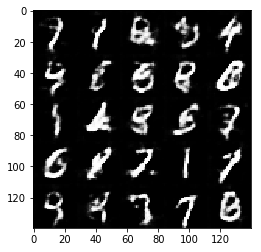

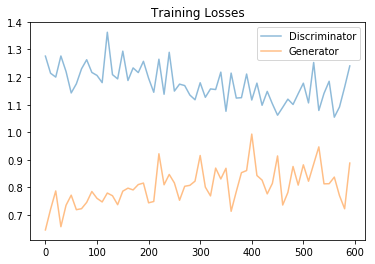

Step 610, Epoch 2/2...
D Loss: 1.0903...
G Loss: 1.0153
Step 620, Epoch 2/2...
D Loss: 1.0763...
G Loss: 0.9898
Step 630, Epoch 2/2...
D Loss: 1.0902...
G Loss: 0.8646
Step 640, Epoch 2/2...
D Loss: 1.0956...
G Loss: 0.9425
Step 650, Epoch 2/2...
D Loss: 1.0661...
G Loss: 0.8982
Step 660, Epoch 2/2...
D Loss: 1.0889...
G Loss: 0.8495
Step 670, Epoch 2/2...
D Loss: 1.0433...
G Loss: 0.9309
Step 680, Epoch 2/2...
D Loss: 1.1381...
G Loss: 0.9942
Step 690, Epoch 2/2...
D Loss: 1.0114...
G Loss: 1.0170
Step 700, Epoch 2/2...
D Loss: 0.9917...
G Loss: 0.9912


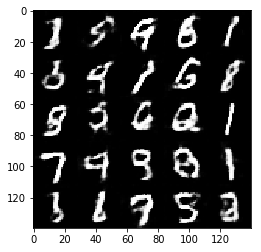

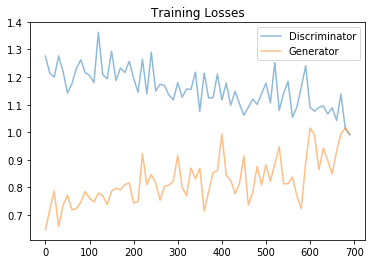

Step 710, Epoch 2/2...
D Loss: 1.0151...
G Loss: 1.0470
Step 720, Epoch 2/2...
D Loss: 1.0296...
G Loss: 0.8233
Step 730, Epoch 2/2...
D Loss: 1.0267...
G Loss: 0.9063
Step 740, Epoch 2/2...
D Loss: 1.1246...
G Loss: 1.0335
Step 750, Epoch 2/2...
D Loss: 1.0351...
G Loss: 0.9373
Step 760, Epoch 2/2...
D Loss: 1.0410...
G Loss: 0.8570
Step 770, Epoch 2/2...
D Loss: 1.1234...
G Loss: 0.8338
Step 780, Epoch 2/2...
D Loss: 0.9896...
G Loss: 0.9344
Step 790, Epoch 2/2...
D Loss: 1.0346...
G Loss: 0.8115
Step 800, Epoch 2/2...
D Loss: 1.0817...
G Loss: 0.8493


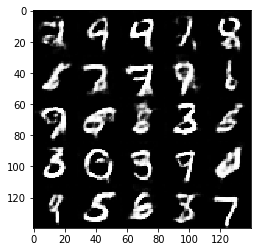

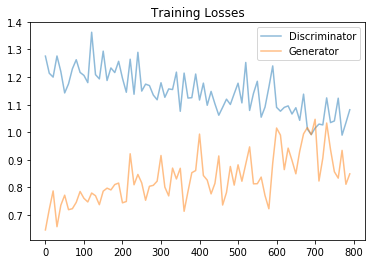

Step 810, Epoch 2/2...
D Loss: 0.9833...
G Loss: 0.9193
Step 820, Epoch 2/2...
D Loss: 1.0098...
G Loss: 0.8229
Step 830, Epoch 2/2...
D Loss: 1.0071...
G Loss: 0.8322
Step 840, Epoch 2/2...
D Loss: 1.0216...
G Loss: 0.9641
Step 850, Epoch 2/2...
D Loss: 1.0461...
G Loss: 0.9328
Step 860, Epoch 2/2...
D Loss: 1.0898...
G Loss: 0.9727
Step 870, Epoch 2/2...
D Loss: 1.0254...
G Loss: 0.9655
Step 880, Epoch 2/2...
D Loss: 1.0359...
G Loss: 0.8925
Step 890, Epoch 2/2...
D Loss: 1.0331...
G Loss: 0.7962
Step 900, Epoch 2/2...
D Loss: 1.0529...
G Loss: 0.9737


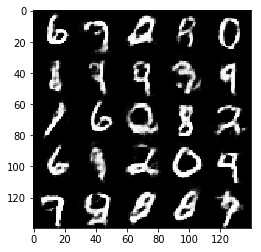

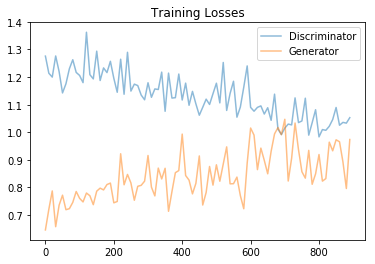

Step 910, Epoch 2/2...
D Loss: 0.9720...
G Loss: 0.9110
Step 920, Epoch 2/2...
D Loss: 1.0063...
G Loss: 0.9608
Step 930, Epoch 2/2...
D Loss: 1.0668...
G Loss: 1.0931


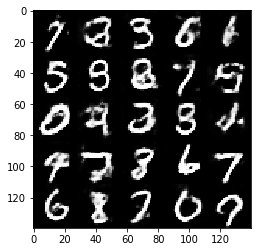

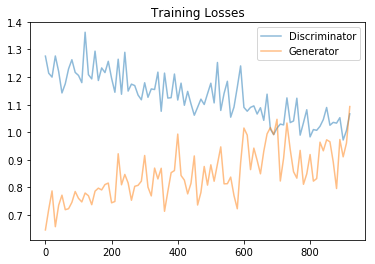

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode)


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 10, Epoch 1/1...
D Loss: 1.1814...
G Loss: 0.9260
Step 20, Epoch 1/1...
D Loss: 1.0818...
G Loss: 0.8833
Step 30, Epoch 1/1...
D Loss: 1.1108...
G Loss: 0.9677
Step 40, Epoch 1/1...
D Loss: 1.1684...
G Loss: 0.6671
Step 50, Epoch 1/1...
D Loss: 1.1504...
G Loss: 0.8477
Step 60, Epoch 1/1...
D Loss: 1.3249...
G Loss: 0.8777
Step 70, Epoch 1/1...
D Loss: 1.1253...
G Loss: 0.8151
Step 80, Epoch 1/1...
D Loss: 1.1124...
G Loss: 0.9377
Step 90, Epoch 1/1...
D Loss: 1.1461...
G Loss: 0.9282
Step 100, Epoch 1/1...
D Loss: 1.0877...
G Loss: 0.8112


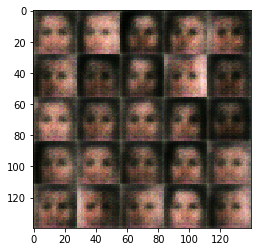

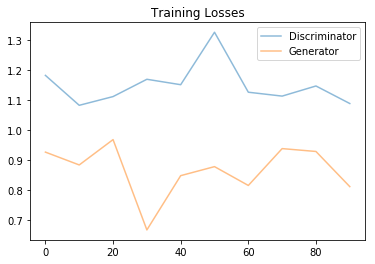

Step 110, Epoch 1/1...
D Loss: 1.1005...
G Loss: 0.8304
Step 120, Epoch 1/1...
D Loss: 1.0276...
G Loss: 0.8320
Step 130, Epoch 1/1...
D Loss: 1.1364...
G Loss: 1.0961
Step 140, Epoch 1/1...
D Loss: 1.3574...
G Loss: 0.7810
Step 150, Epoch 1/1...
D Loss: 1.0997...
G Loss: 0.8122
Step 160, Epoch 1/1...
D Loss: 1.3097...
G Loss: 0.9573
Step 170, Epoch 1/1...
D Loss: 1.1903...
G Loss: 0.8279
Step 180, Epoch 1/1...
D Loss: 1.0735...
G Loss: 0.8360
Step 190, Epoch 1/1...
D Loss: 1.1026...
G Loss: 0.7943
Step 200, Epoch 1/1...
D Loss: 1.2679...
G Loss: 0.6345


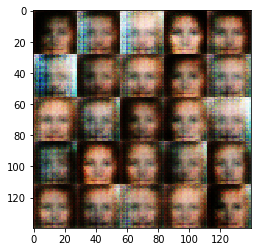

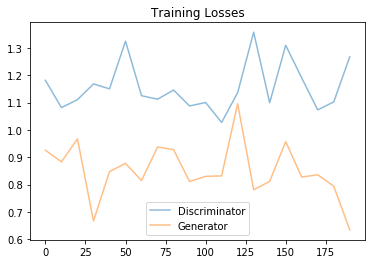

Step 210, Epoch 1/1...
D Loss: 1.2271...
G Loss: 0.7756
Step 220, Epoch 1/1...
D Loss: 1.2325...
G Loss: 0.7610
Step 230, Epoch 1/1...
D Loss: 1.1358...
G Loss: 0.7742
Step 240, Epoch 1/1...
D Loss: 1.2096...
G Loss: 0.7649
Step 250, Epoch 1/1...
D Loss: 1.2623...
G Loss: 0.7364
Step 260, Epoch 1/1...
D Loss: 1.3709...
G Loss: 0.6297
Step 270, Epoch 1/1...
D Loss: 1.2553...
G Loss: 0.7203
Step 280, Epoch 1/1...
D Loss: 1.3444...
G Loss: 0.6401
Step 290, Epoch 1/1...
D Loss: 1.1905...
G Loss: 0.6864
Step 300, Epoch 1/1...
D Loss: 1.2098...
G Loss: 0.7630


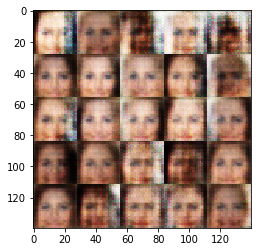

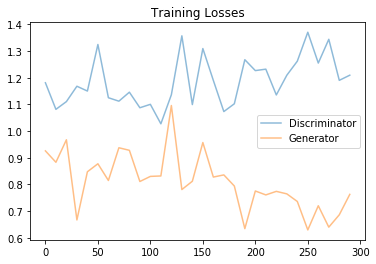

Step 310, Epoch 1/1...
D Loss: 1.1807...
G Loss: 0.7562
Step 320, Epoch 1/1...
D Loss: 1.2780...
G Loss: 0.5861
Step 330, Epoch 1/1...
D Loss: 1.2097...
G Loss: 0.7752
Step 340, Epoch 1/1...
D Loss: 1.2301...
G Loss: 0.7248
Step 350, Epoch 1/1...
D Loss: 1.1634...
G Loss: 0.8038
Step 360, Epoch 1/1...
D Loss: 1.1136...
G Loss: 0.8497
Step 370, Epoch 1/1...
D Loss: 1.2099...
G Loss: 0.7480
Step 380, Epoch 1/1...
D Loss: 1.2216...
G Loss: 0.7214
Step 390, Epoch 1/1...
D Loss: 1.2738...
G Loss: 0.6073
Step 400, Epoch 1/1...
D Loss: 1.2303...
G Loss: 0.7817


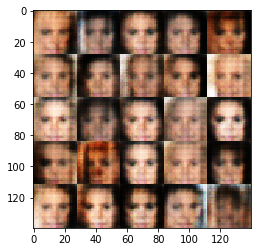

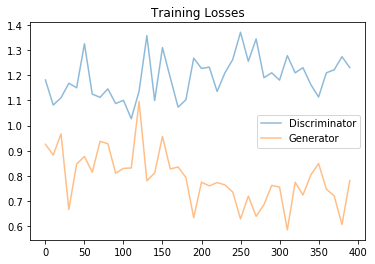

Step 410, Epoch 1/1...
D Loss: 1.3285...
G Loss: 0.7324
Step 420, Epoch 1/1...
D Loss: 1.2648...
G Loss: 0.7216
Step 430, Epoch 1/1...
D Loss: 1.1489...
G Loss: 0.7883
Step 440, Epoch 1/1...
D Loss: 1.1691...
G Loss: 0.8874
Step 450, Epoch 1/1...
D Loss: 1.1967...
G Loss: 0.6766
Step 460, Epoch 1/1...
D Loss: 1.1303...
G Loss: 0.6955
Step 470, Epoch 1/1...
D Loss: 1.1663...
G Loss: 0.7159
Step 480, Epoch 1/1...
D Loss: 1.1978...
G Loss: 0.7253
Step 490, Epoch 1/1...
D Loss: 1.1695...
G Loss: 0.8277
Step 500, Epoch 1/1...
D Loss: 1.1844...
G Loss: 0.7368


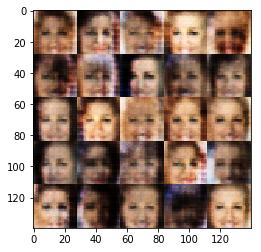

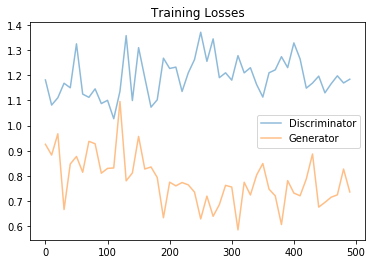

Step 510, Epoch 1/1...
D Loss: 1.1027...
G Loss: 0.7633
Step 520, Epoch 1/1...
D Loss: 1.2115...
G Loss: 0.8256
Step 530, Epoch 1/1...
D Loss: 1.2363...
G Loss: 0.7145
Step 540, Epoch 1/1...
D Loss: 1.2078...
G Loss: 0.7376
Step 550, Epoch 1/1...
D Loss: 1.1528...
G Loss: 0.9244
Step 560, Epoch 1/1...
D Loss: 1.1237...
G Loss: 0.7353
Step 570, Epoch 1/1...
D Loss: 1.1952...
G Loss: 0.8664
Step 580, Epoch 1/1...
D Loss: 1.1632...
G Loss: 0.7630
Step 590, Epoch 1/1...
D Loss: 1.1862...
G Loss: 0.7675
Step 600, Epoch 1/1...
D Loss: 1.2363...
G Loss: 0.7404


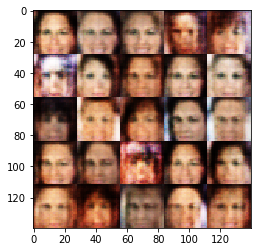

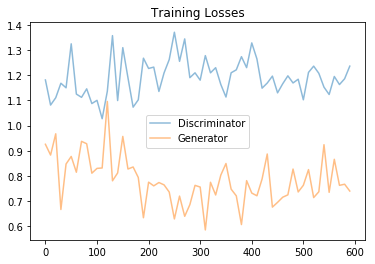

Step 610, Epoch 1/1...
D Loss: 1.1262...
G Loss: 0.6641
Step 620, Epoch 1/1...
D Loss: 1.2567...
G Loss: 0.7198
Step 630, Epoch 1/1...
D Loss: 1.2234...
G Loss: 0.7228
Step 640, Epoch 1/1...
D Loss: 1.2166...
G Loss: 0.6654
Step 650, Epoch 1/1...
D Loss: 1.1810...
G Loss: 0.9293
Step 660, Epoch 1/1...
D Loss: 1.2065...
G Loss: 0.6941
Step 670, Epoch 1/1...
D Loss: 1.1803...
G Loss: 0.7606
Step 680, Epoch 1/1...
D Loss: 1.1826...
G Loss: 0.7981
Step 690, Epoch 1/1...
D Loss: 1.2044...
G Loss: 0.6865
Step 700, Epoch 1/1...
D Loss: 1.3168...
G Loss: 0.6992


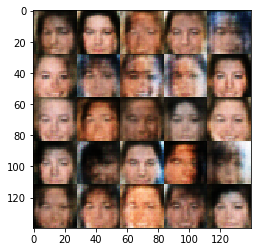

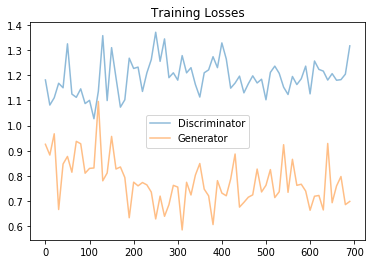

Step 710, Epoch 1/1...
D Loss: 1.1042...
G Loss: 0.7598
Step 720, Epoch 1/1...
D Loss: 1.1410...
G Loss: 0.7605
Step 730, Epoch 1/1...
D Loss: 1.2840...
G Loss: 0.8480
Step 740, Epoch 1/1...
D Loss: 1.1774...
G Loss: 0.7135
Step 750, Epoch 1/1...
D Loss: 1.1250...
G Loss: 0.9105
Step 760, Epoch 1/1...
D Loss: 1.0949...
G Loss: 0.8916
Step 770, Epoch 1/1...
D Loss: 1.0726...
G Loss: 0.9127
Step 780, Epoch 1/1...
D Loss: 1.1523...
G Loss: 0.6685
Step 790, Epoch 1/1...
D Loss: 1.2047...
G Loss: 0.8159
Step 800, Epoch 1/1...
D Loss: 1.1094...
G Loss: 0.7320


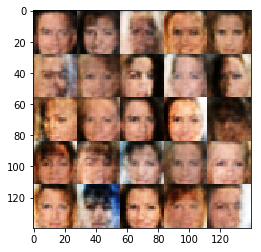

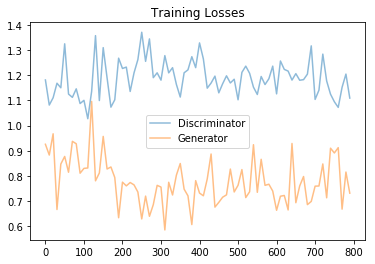

Step 810, Epoch 1/1...
D Loss: 1.1486...
G Loss: 0.6903
Step 820, Epoch 1/1...
D Loss: 1.2314...
G Loss: 0.7093
Step 830, Epoch 1/1...
D Loss: 1.2201...
G Loss: 0.7008
Step 840, Epoch 1/1...
D Loss: 1.1190...
G Loss: 0.7019
Step 850, Epoch 1/1...
D Loss: 1.1314...
G Loss: 0.9084
Step 860, Epoch 1/1...
D Loss: 1.1086...
G Loss: 0.7994
Step 870, Epoch 1/1...
D Loss: 1.1500...
G Loss: 0.7121
Step 880, Epoch 1/1...
D Loss: 1.2230...
G Loss: 0.6532
Step 890, Epoch 1/1...
D Loss: 1.1593...
G Loss: 0.8208
Step 900, Epoch 1/1...
D Loss: 1.0812...
G Loss: 0.9032


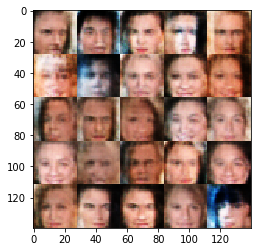

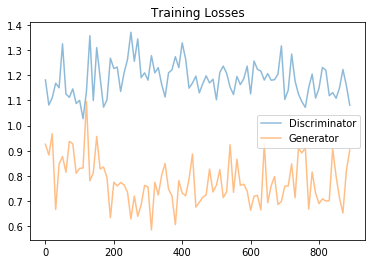

Step 910, Epoch 1/1...
D Loss: 1.1449...
G Loss: 0.8543
Step 920, Epoch 1/1...
D Loss: 1.0641...
G Loss: 0.8981
Step 930, Epoch 1/1...
D Loss: 1.2154...
G Loss: 0.7545
Step 940, Epoch 1/1...
D Loss: 1.2248...
G Loss: 0.7107
Step 950, Epoch 1/1...
D Loss: 1.2079...
G Loss: 0.6755
Step 960, Epoch 1/1...
D Loss: 1.1884...
G Loss: 0.7000
Step 970, Epoch 1/1...
D Loss: 1.1404...
G Loss: 0.7777
Step 980, Epoch 1/1...
D Loss: 1.1409...
G Loss: 0.8798
Step 990, Epoch 1/1...
D Loss: 1.2414...
G Loss: 0.6221
Step 1000, Epoch 1/1...
D Loss: 1.1576...
G Loss: 0.7205


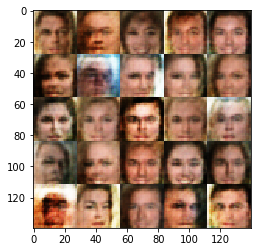

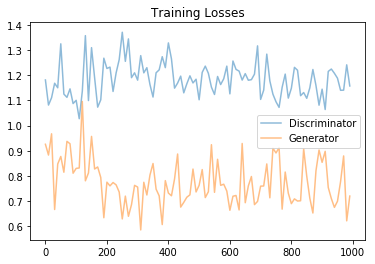

Step 1010, Epoch 1/1...
D Loss: 1.1245...
G Loss: 0.7159
Step 1020, Epoch 1/1...
D Loss: 1.1530...
G Loss: 0.7238
Step 1030, Epoch 1/1...
D Loss: 1.1749...
G Loss: 0.7119
Step 1040, Epoch 1/1...
D Loss: 1.2038...
G Loss: 0.8492
Step 1050, Epoch 1/1...
D Loss: 1.2154...
G Loss: 0.7640
Step 1060, Epoch 1/1...
D Loss: 1.1231...
G Loss: 0.7776
Step 1070, Epoch 1/1...
D Loss: 1.1789...
G Loss: 0.9335
Step 1080, Epoch 1/1...
D Loss: 1.1899...
G Loss: 0.9449
Step 1090, Epoch 1/1...
D Loss: 1.2302...
G Loss: 0.6682
Step 1100, Epoch 1/1...
D Loss: 1.1158...
G Loss: 0.8147


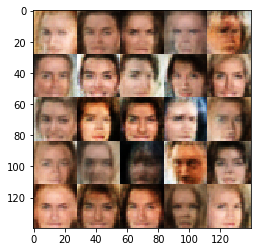

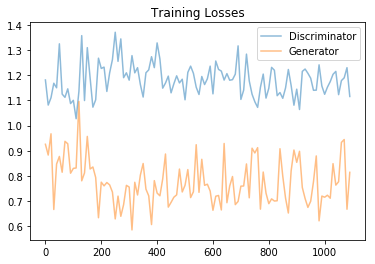

Step 1110, Epoch 1/1...
D Loss: 1.1492...
G Loss: 0.8762
Step 1120, Epoch 1/1...
D Loss: 1.1396...
G Loss: 0.7934
Step 1130, Epoch 1/1...
D Loss: 1.0848...
G Loss: 0.8977
Step 1140, Epoch 1/1...
D Loss: 1.1045...
G Loss: 0.9072
Step 1150, Epoch 1/1...
D Loss: 1.0996...
G Loss: 0.8344
Step 1160, Epoch 1/1...
D Loss: 1.1495...
G Loss: 0.9386
Step 1170, Epoch 1/1...
D Loss: 1.1489...
G Loss: 0.7784
Step 1180, Epoch 1/1...
D Loss: 1.1691...
G Loss: 0.8508
Step 1190, Epoch 1/1...
D Loss: 1.0780...
G Loss: 0.8402
Step 1200, Epoch 1/1...
D Loss: 1.1729...
G Loss: 0.6542


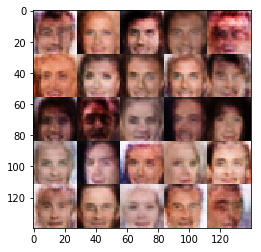

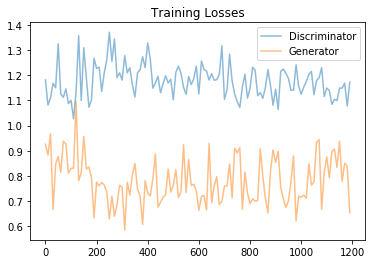

Step 1210, Epoch 1/1...
D Loss: 1.1809...
G Loss: 0.7069
Step 1220, Epoch 1/1...
D Loss: 1.1245...
G Loss: 0.7342
Step 1230, Epoch 1/1...
D Loss: 1.1557...
G Loss: 0.7630
Step 1240, Epoch 1/1...
D Loss: 1.1592...
G Loss: 0.7361
Step 1250, Epoch 1/1...
D Loss: 1.1242...
G Loss: 0.8324
Step 1260, Epoch 1/1...
D Loss: 1.1769...
G Loss: 0.8610
Step 1270, Epoch 1/1...
D Loss: 1.1124...
G Loss: 0.8477
Step 1280, Epoch 1/1...
D Loss: 1.0815...
G Loss: 0.7774
Step 1290, Epoch 1/1...
D Loss: 1.1266...
G Loss: 0.8489
Step 1300, Epoch 1/1...
D Loss: 1.0132...
G Loss: 0.8280


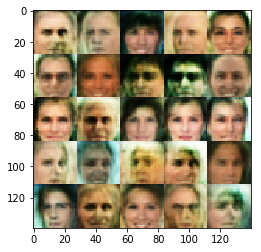

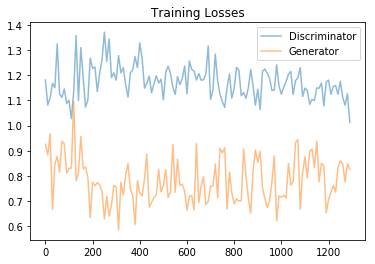

Step 1310, Epoch 1/1...
D Loss: 1.1566...
G Loss: 0.7538
Step 1320, Epoch 1/1...
D Loss: 1.2247...
G Loss: 0.7146
Step 1330, Epoch 1/1...
D Loss: 1.1370...
G Loss: 0.7362
Step 1340, Epoch 1/1...
D Loss: 1.1834...
G Loss: 0.6070
Step 1350, Epoch 1/1...
D Loss: 1.0743...
G Loss: 0.7799
Step 1360, Epoch 1/1...
D Loss: 1.1085...
G Loss: 0.8496
Step 1370, Epoch 1/1...
D Loss: 1.0613...
G Loss: 0.8268
Step 1380, Epoch 1/1...
D Loss: 1.1563...
G Loss: 0.7897
Step 1390, Epoch 1/1...
D Loss: 1.1322...
G Loss: 0.8756
Step 1400, Epoch 1/1...
D Loss: 1.1267...
G Loss: 0.6605


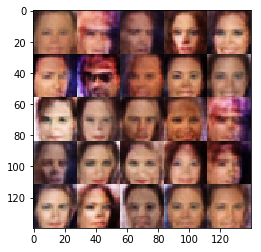

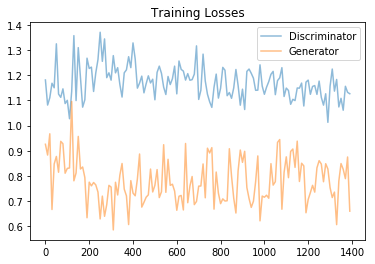

Step 1410, Epoch 1/1...
D Loss: 1.0978...
G Loss: 0.9209
Step 1420, Epoch 1/1...
D Loss: 1.1281...
G Loss: 0.9403
Step 1430, Epoch 1/1...
D Loss: 1.1744...
G Loss: 0.6318
Step 1440, Epoch 1/1...
D Loss: 1.1315...
G Loss: 0.9170
Step 1450, Epoch 1/1...
D Loss: 1.1167...
G Loss: 0.6803
Step 1460, Epoch 1/1...
D Loss: 1.0943...
G Loss: 0.9628
Step 1470, Epoch 1/1...
D Loss: 1.1674...
G Loss: 0.7785
Step 1480, Epoch 1/1...
D Loss: 1.0859...
G Loss: 0.7039
Step 1490, Epoch 1/1...
D Loss: 1.1325...
G Loss: 0.9274
Step 1500, Epoch 1/1...
D Loss: 1.0844...
G Loss: 0.7152


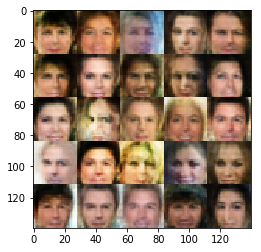

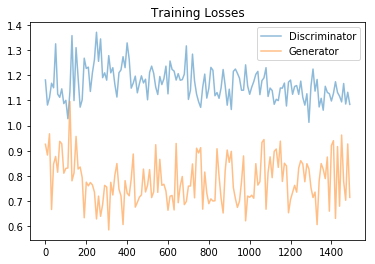

Step 1510, Epoch 1/1...
D Loss: 1.1337...
G Loss: 0.6559
Step 1520, Epoch 1/1...
D Loss: 1.0902...
G Loss: 0.8609
Step 1530, Epoch 1/1...
D Loss: 1.1043...
G Loss: 0.8101
Step 1540, Epoch 1/1...
D Loss: 1.1008...
G Loss: 0.9581
Step 1550, Epoch 1/1...
D Loss: 1.1931...
G Loss: 0.7075
Step 1560, Epoch 1/1...
D Loss: 1.0478...
G Loss: 0.9342
Step 1570, Epoch 1/1...
D Loss: 1.0306...
G Loss: 0.7800
Step 1580, Epoch 1/1...
D Loss: 1.1720...
G Loss: 0.6561


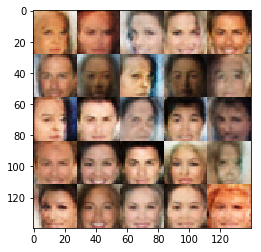

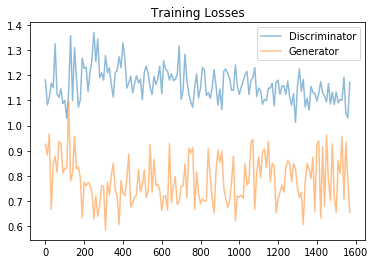

In [13]:
batch_size = 128 
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.